<a href="https://colab.research.google.com/github/magno12345/UPSO/blob/main/Lab_clasificador_de_canciones_de_Spotify_MAGNO_SOTELO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Carga de csv y limpieza

Cargue el csv y elimine la columna "key" porque representa la tonalidad musical, una característica discreta que no aporta información cuantitativa relevante para el analisis. La exclusión del atributo 'mode' sigue una lógica similar, ya que comparte características cualitativas con 'key' que no son útiles para el análisis,la columna duration_ms tampoco la use porque a las personas le pueden gustar canciones de 1 min o hasta 10 min ,no la vi relevante,el time_signature(compas musical) lo descarte porque es para que los músicos  compongan de manera correcta en términos de ritmo y duración de las notas,lo vi irrelevante digamos.no use el atributo tempo y valence porque me da mejores metricas sin ellos.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#cargo el csv
df = pd.read_csv("/content/drive/MyDrive/DATASETS BIG DATA/Canciones_Spotify.csv").drop(columns=['key', 'mode', 'time_signature',"Unnamed: 0"])

# Filtre las celdas de la clase 1 para que este balanceado
celdas_a_eliminar = df[df['target'] == 1].sample(23)

# Elimino las celdas seleccionadas del df
df = df.drop(celdas_a_eliminar.index)
#df.isna().sum()


##Grafico de boxplot para identificar outliers.

Parece que todos tienen outliers,pero para identifificar los verdaderos tendria que haber un dato negativo donde no tendria q haber.por ejemplo,no puede hacer una edad de 213 o una edad negativa.

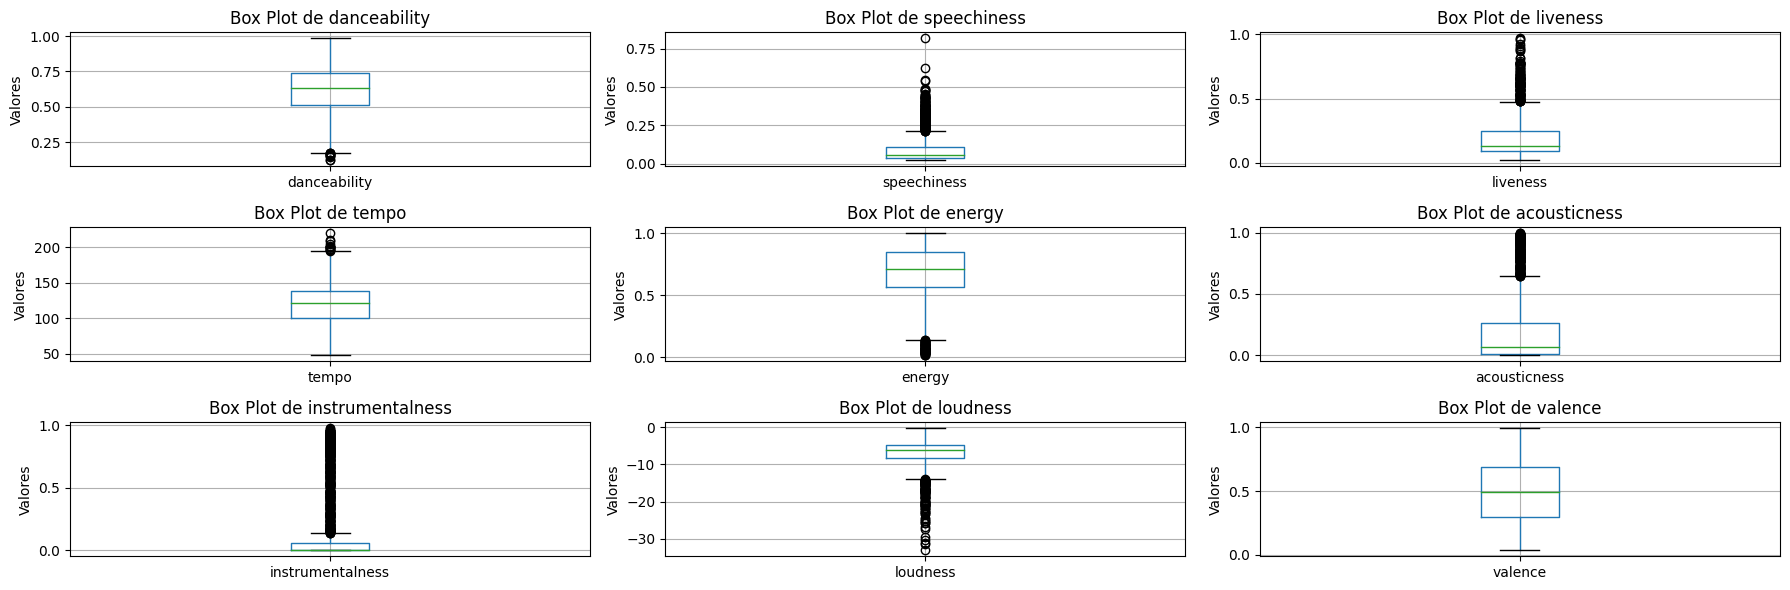

In [ ]:
#HAGO graficos de boxplot para identificar outliers,
def boxplots_for_columns_3_columns(df, columns, subplot_width=6, subplot_height=2):
    num_columns = len(columns)
    num_rows = (num_columns // 3) + (num_columns % 3 > 0)  # Calcula el número de filas para los subplots

    fig, axes = plt.subplots(num_rows, 3, figsize=(subplot_width * 3, subplot_height * num_rows))  # Ajusta el tamaño de los subplots

    for i, column in enumerate(columns):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        df.boxplot(column=column, ax=ax)
        ax.set_title(f'Box Plot de {column}')
        ax.set_ylabel('Valores')

    # Elimina subplots no utilizados
    for i in range(num_columns, num_rows * 3):
        fig.delaxes(axes[i // 3, i % 3])

    plt.tight_layout()
    plt.show()
columnas_a_visualizar = ['danceability', 'speechiness', 'liveness', 'tempo', 'energy', 'acousticness', 'instrumentalness', 'loudness', 'valence']
boxplots_for_columns_3_columns(df,columnas_a_visualizar)

##Histograma de todos los  atributos.




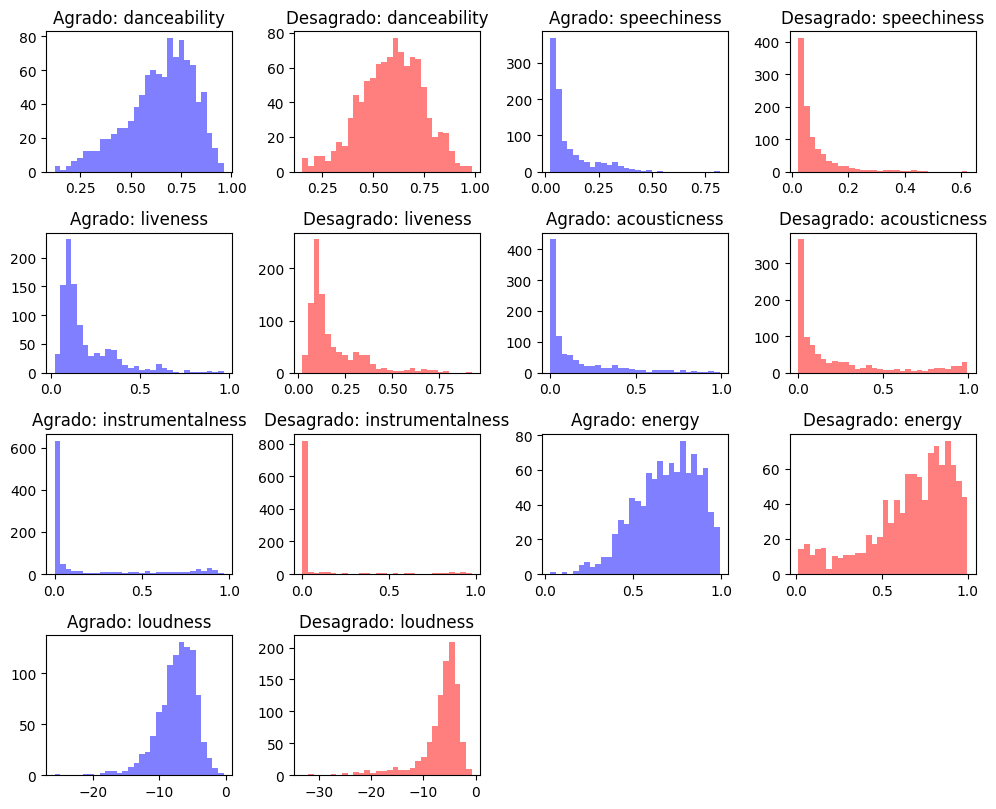

In [ ]:
#df.hist(bins = 30, figsize = (10, 8));
import matplotlib.pyplot as plt

# Divido el DataFrame en dos grupos según la clase (target)
clase_agrado = df[df['target'] == 1]
clase_desagrado = df[df['target'] == 0]

# Listo de características que quiero incluir en los histogramas
caracteristicas = ['danceability', 'speechiness', 'liveness',
                   "acousticness", "instrumentalness", "energy", "loudness"]

# Configuro la disposición de los subplots
filas = len(caracteristicas)
columnas = 4  #  subplots por fila (para "agrado" y "desagrado")

# Calculo el número total de subplots necesarios
num_subplots = len(caracteristicas) * 4

# Cro subplots para todas las características
plt.figure(figsize=(10, 2 * filas))

for i, caracteristica in enumerate(caracteristicas):
    plt.subplot(filas, columnas, i * 2 + 1)
    plt.hist(clase_agrado[caracteristica], bins=30, alpha=0.5, color='blue')
    plt.title(f'Agrado: {caracteristica}')

    plt.subplot(filas, columnas, i * 2 + 2)
    plt.hist(clase_desagrado[caracteristica], bins=30, alpha=0.5, color='red')
    plt.title(f'Desagrado: {caracteristica}')

plt.tight_layout()
plt.show()


##Preparo los datos(escalar)





En esta parte tenia dudas de si pasarlo a numpy la x ,pero me di cuenta que al escalarlo ya se transformaban a array,otra inquietud fue si era necesario escalarlo ya que normalmente se escalan si por ejemplo: en una columna los valores son de 6 cifras y el resto de las columnas tienen valores de 0,00021,ahi es necesario ya que los valores tienen que estar en un mismo rango.

Una prueba que hice fue con 2 atributos,use energy y loudness porque tenian mas correlatividad que el resto ,use la matriz de correlacion mas abajo,para ver si tenian correlacion los numeros se tenian q hacer mas al 1 o -1 para ser tomados en cuenta,lo hice y no tuvieron mucha diferencia usando las 5 caracteristicas o 2.

In [ ]:
#tomo solo las columnas que voy a necesitar para el modelo
x = df[['danceability',"energy","loudness" ,'speechiness', 'liveness', 'acousticness',"instrumentalness"]] #.to_numpy()
#x = df[[ 'energy' ,'loudness']]#esto fue una prueba de la matriz de correlacion
y = df[['target']].values.ravel()#etiquetas 1 y 0

from sklearn.preprocessing import MinMaxScaler
escalador = MinMaxScaler(feature_range=( 0, 1))
x_escalada = escalador.fit_transform(x)
#hago un for para mostrar como quedo escalada la x.
for i in range(x_escalada.shape[1]):
  print(f"{x.keys()[i]}\t Min:{escalador.data_min_[i]}\t Max:{escalador.data_max_[i]}")

danceability	 Min:0.122	 Max:0.984
energy	 Min:0.0148	 Max:0.998
loudness	 Min:-33.097	 Max:-0.307
speechiness	 Min:0.0231	 Max:0.816
liveness	 Min:0.0188	 Max:0.969
acousticness	 Min:2.84e-06	 Max:0.995
instrumentalness	 Min:0.0	 Max:0.976


##Matriz de correlacion.

hay correlacion entre energy y loudness(0,76)




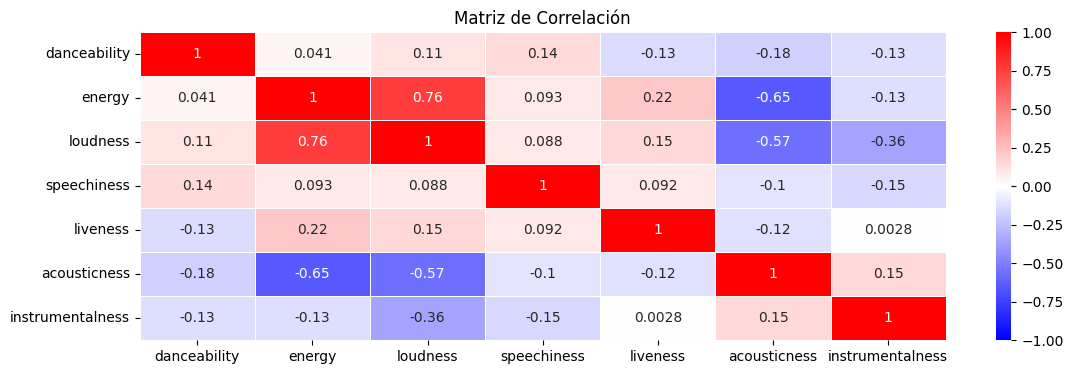

In [ ]:
#Matriz de correlación
correlation_matrix = x.corr()

# Creo un mapa de calor (heatmap)
plt.figure(figsize=(13, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='bwr', linewidths=0.5,vmin=-1)
plt.title('Matriz de Correlación')
plt.xticks(rotation=360)
plt.show()


##Creo el clasificador KNN,los datos prueba-testeo y la matriz de confusion.

NOTA : cuando se ejecute el codigo en otra maquina se veran otros resultados ,aun teniendo el random_state 0 o 25,tambien las funciones de encontrar_mejor_k y los hiperparametros.

La matriz de confusion casi siempre me da que se equivoco en ambos casos desagrado y agrado valores entre 50 y 70,y acerto mas de 150 veces bien en desagrado y almenos mas de 110 agrado(pueden variar).

He ido probando diferentes k ,random_state,test_size manualmente,porque no me guie x las funciones por lo dicho anteriormente,esos son los mejores parametros que pude alcanzar, jugando con los parametros.

exactitud de datos de entrenamiento 0.7218045112781954
exactitud de datos de testeo 0.8025078369905956


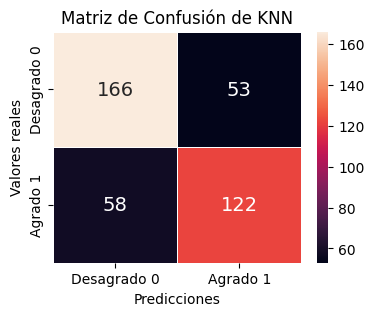

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_escalada, y, test_size=0.2,random_state=25)#25

def generate_clf_KNN(k, x_train, y_train):
    clasificadorKNN = KNeighborsClassifier(n_neighbors=k,metric="euclidean")#use esta metrica por recomendacion de los hiperparametros.
    clasificadorKNN.fit(x_train, y_train.ravel())
    return clasificadorKNN

knn = generate_clf_KNN(5,x_train,y_train)
#k=5
#y_pred son los target predecidos del modelo
y_pred = knn.predict(x_test)

print("exactitud de datos de entrenamiento",knn.score(x_test,y_test))
print("exactitud de datos de testeo",knn.score(x_train,y_train))
#matriz de confusion de KNN
c = confusion_matrix(y_test,y_pred)


def matriz_confusion(matrix,nombre_model=""):
    # Convierte la matriz de confusión a una lista de listas de cadenas
    confusion_matrix_str = [[str(value) for value in row] for row in matrix]

    # Crea un gráfico de matriz de confusión con Seaborn
    plt.figure(figsize=(4, 3))
    sns.heatmap(matrix, annot=True, fmt='g', linewidths=0.5, annot_kws={"size": 14}, xticklabels=['Desagrado 0', 'Agrado 1'], yticklabels=['Desagrado 0', 'Agrado 1'])
    plt.xlabel('Predicciones')
    plt.ylabel('Valores reales')
    plt.title(f'Matriz de Confusión de {nombre_model}')
    plt.show()

matriz_confusion(c,"KNN")


In [ ]:
from sklearn.model_selection import cross_val_score

# Realizo validación cruzada y obténgo las puntuaciones
puntuaciones_knn = cross_val_score(knn, x_escalada, y, cv=5, scoring='accuracy')

# Imprimo las puntuaciones
print("Puntuaciones de Validación Cruzada de KNN:", puntuaciones_knn)
print("Puntuación Promedio:", puntuaciones_knn.mean())

Puntuaciones de Validación Cruzada de KNN: [0.71177945 0.6566416  0.55889724 0.63909774 0.66331658]
Puntuación Promedio: 0.6459465246029646


##Encontrar los mejores parametros con RandomSearchCV

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define el espacio de búsqueda de hiperparámetros
parametros = {
    'n_neighbors': range(1, 30),           # Número de vecinos
    'weights': ['uniform', 'distance'],     # Tipo de ponderación le añade peso a los puntos
    'metric': ['euclidean', 'manhattan'],  # Métrica de distancia
    'p': [1, 2], # Parámetro de distancia (1 para Manhattan, 2 para Euclidiana)

}
# Se crea un modelo KNN
knn = KNeighborsClassifier()

# Realiza la búsqueda aleatoria
random_search = RandomizedSearchCV(knn, param_distributions=parametros, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search.fit(x_train, y_train)

# Muestra los mejores hiperparámetros y la puntuación
print("Mejores hiperparámetros encontrados:",random_search.best_params_)
print("Puntuación del modelo con los mejores hiperparámetros:",random_search.best_score_ )

Mejores hiperparámetros encontrados: {'weights': 'distance', 'p': 2, 'n_neighbors': 28, 'metric': 'manhattan'}
Puntuación del modelo con los mejores hiperparámetros: 0.6890282131661442


Creo un reporte con distintos puntajes y distintas metricas

In [ ]:
reporte =classification_report(y_test,y_pred)
print(reporte)

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       219
           1       0.70      0.68      0.69       180

    accuracy                           0.72       399
   macro avg       0.72      0.72      0.72       399
weighted avg       0.72      0.72      0.72       399



###Busco el mejor k y puntaje.

El puntaje es: 0.6776495629668722
El mejor valor de k es 3


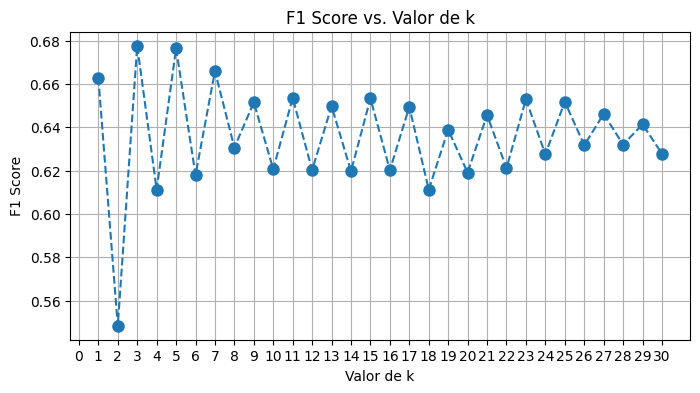

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

def encontrar_mejor_k(X, y, max_k=30, metric="", cv=5):
    k_values = list(range(1, max_k + 1))
    accuracies = []

    # Obtener el nombre de la métrica
    metric_name = ""
    if metric == "f1":
        metric_name = "F1 Score"
    elif metric == "accuracy":
        metric_name = "Exactitud"
    elif metric == "precision":
         metric_name = "Precision"
    elif metric == "recall":
         metric_name = "recall_score"


    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv, scoring=metric)
        accuracies.append(scores.mean())

    # Encontrar el valor de k con la métrica más alta
    mejor_k = k_values[np.argmax(accuracies)]

    # Imprimir el puntaje obtenido para el mejor valor de k
    print(f"El puntaje es: {accuracies[np.argmax(accuracies)]}")
    print(f"El mejor valor de k es {mejor_k}")

    # Gráfico de k vs. métrica
    plt.figure(figsize=(8, 4))
    plt.plot(k_values, accuracies, marker='o', linestyle='dashed', markersize=8)
    plt.title(f'{metric_name} vs. Valor de k')
    plt.xlabel('Valor de k')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.xticks(range(31))

    plt.show()


    return mejor_k


mejor_k = encontrar_mejor_k(x_train, y_train, metric="f1", cv=5)


Para visualizar un poco ,use un PCA ,tuve que reducir las dimenciones porque use 7 atributos,se ve que es dificil separar las caracteristicas viendo el histograma de los atributos se puede ver que los atributos son muy parecidos,por eso el score no da mas de 60 o 70 aveces.

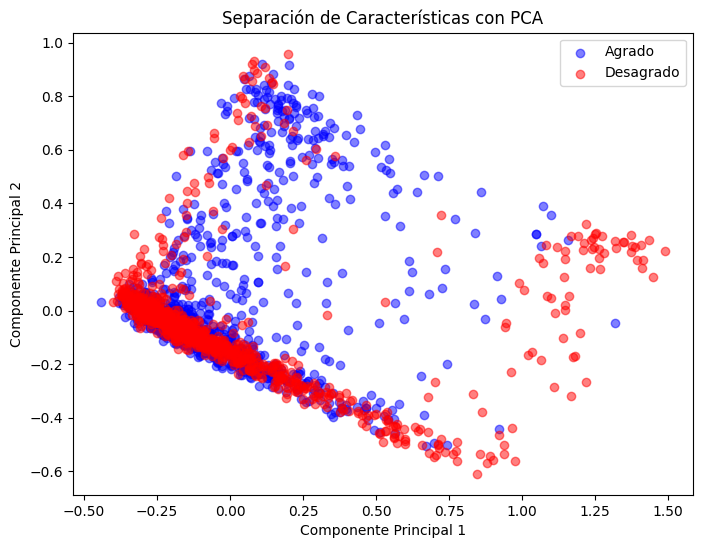

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_escalada)

# Creo un gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(x_pca[y == 1, 0], x_pca[y == 1, 1], label='Agrado', c='blue', alpha=0.5)
plt.scatter(x_pca[y == 0, 0], x_pca[y == 0, 1], label='Desagrado', c='red', alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.title('Separación de Características con PCA')
plt.show()


##SVM

En la matriz de confusion de este modelo se ve que acerto un poco mas que knn

NOTA: en el momento de la ejecucion capaz que dara valores diferentes.




Accuracy using linear: 0.6842105263157895
Accuracy using rbf: 0.7393483709273183
Accuracy using poly: 0.7343358395989975


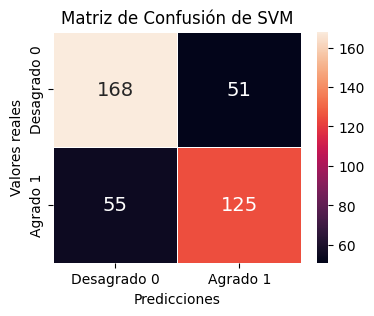

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


kernels = ['linear', 'rbf', 'poly']

for kernel in kernels:

    model = SVC(kernel=kernel,C=2,gamma=4)#kernel=poly
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    print("Accuracy using {}:".format(kernel), accuracy_score(pred, y_test))

#mejores parametros actuales usando randomsearch
sbc = SVC(kernel="poly", C=2, gamma = 4)#Creo el modelo SVM
sbc.fit(x_train, y_train)
sbc_pred = sbc.predict(x_test)
c2 = confusion_matrix(y_test,sbc_pred)
matriz_confusion(c2,"SVM")

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
#Creo una instancia svc para calcular el puntaje
ins=SVC(kernel="poly",C=2,gamma=4)#Despues de ajustar los parametros paso de 0.61 a 0.69 de promedio
# Realizo validación cruzada y obténgo las puntuaciones
puntuaciones = cross_val_score(ins, x_escalada, y, cv=5, scoring='accuracy')

# Imprimo las puntuaciones
print("Puntuaciones de Validación Cruzada de SVC:", puntuaciones)
print("Puntuación Promedio:", puntuaciones.mean())


Puntuaciones de Validación Cruzada de SVC: [0.7518797  0.70426065 0.57142857 0.68922306 0.72613065]
Puntuación Promedio: 0.6885845266432413


La busqueda de los hiperparametros tarda mucho en ejecutarse debido a que le di muchas varibles asique la comente.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': [ 'rbf',"poly"], 'C': [0.1, 1,2,3,4,10], 'gamma': [0.1, 1,2,3,4,10]}
svc = SVC()
clf1 = RandomizedSearchCV(svc, parameters, scoring='f1_macro')
#clf1.fit(x_train, y_train)

#print("Mejores parámetros:", clf1.best_params_)

#print("Mejor score:", clf1.best_score_)


##Arbol de decision.


Hay una forma de visualizar el arbol ,pero no lo hice porque se veria pequeño.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

arb_dec = tree.DecisionTreeClassifier(criterion="entropy",max_depth = 5,min_samples_split=5)

arbol = arb_dec.fit(x_train,y_train)#CREO el modelo

accu = arb_dec.score(x_train,y_train)
print("Puntuacion solo del modelo =",accu)
# Realizo validación cruzada y obténgo las puntuaciones
puntuaciones_ar = cross_val_score(arb_dec, x_escalada, y, cv=5, scoring='accuracy')
#targets predecidos x el arbol
y_pred_arbol = arb_dec.predict(x_test)

# Imprimo las puntuaciones
print("Puntuaciones de Validación Cruzada de arbol de decision:", puntuaciones_ar)
print("Puntuación Promedio:", puntuaciones_ar.mean())


Puntuacion solo del modelo = 0.7667711598746082
Puntuaciones de Validación Cruzada de arbol de decision: [0.69423559 0.67669173 0.61403509 0.72180451 0.74623116]
Puntuación Promedio: 0.6905996146144255


En la matriz son valores parecidos a los otros modelos

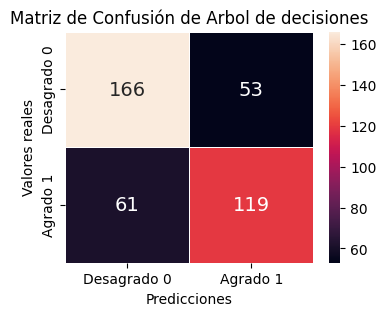

In [ ]:
matriz_arbol = confusion_matrix(y_test,y_pred_arbol)

matriz_confusion(matriz_arbol,"Arbol de decisiones")


Hallo los mejores parametros para el arbol

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

def encontrar_mejores_parametros_arbol(x, y):
    # Define el modelo de árbol de decisión
    arbol1 = DecisionTreeClassifier()

    #  hiperparámetros a explorar
    parametros = {
        'criterion': ['gini', 'entropy'],  # Criterio de división
        'max_depth': [None,1,2,3,4,5,6,7,8,9,10,11],  # Profundidad máxima del árbol(ramas)
        'min_samples_split': [5,8,10,12],  # Mínimo de muestras para dividir un nodo interno
        'min_samples_leaf': [1, 2, 3,4,5,6]  # Mínimo de muestras requeridas en un nodo hoja
    }

    #  búsqueda de hiperparámetros con validación cruzada
    grid_search = GridSearchCV(arbol1, parametros, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(x, y)

    #  mejores hiperparámetros encontrados
    mejores_parametros = grid_search.best_params_
    mejor_puntuacion = grid_search.best_score_

    return mejores_parametros, mejor_puntuacion


mejores_parametros, mejor_puntuacion = encontrar_mejores_parametros_arbol(x_escalada, y)
print("Mejores Parámetros:", mejores_parametros)
print("Mejor Puntuación:", mejor_puntuacion)


Mejores Parámetros: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 8}
Mejor Puntuación: 0.6911008677472575


#Modelo Naive Bayes

este modelo es interesante porque toma los atributos x separado y de ahi calcula la probalidad de que sea de agrado o desagrado,hace una suposicion "ingenua" digamos

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf_naive_bayes = GaussianNB(priors=[0.5, 0.5],var_smoothing=1e-09)#creo el modelo de bayes

clf_naive_bayes.fit(x_train,y_train)
y_pred_nb = clf_naive_bayes.predict(x_test)#targets predecidos x el modelo
matriz_nv = confusion_matrix(y_test,y_pred_nb)
print(classification_report(y_test,y_pred_nb))
#da casi lo mismo a los otros modelos

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       219
           1       0.63      0.68      0.66       180

    accuracy                           0.68       399
   macro avg       0.68      0.68      0.68       399
weighted avg       0.68      0.68      0.68       399



In [ ]:
# Realizo validación cruzada y obténgo las puntuaciones
puntuaciones_nb = cross_val_score(clf_naive_bayes, x_escalada, y, cv=5, scoring='accuracy')
#targets predecidos x el naybe bayes
y_pred_bayes = clf_naive_bayes.predict(x_test)

# Imprimo las puntuaciones
print("Puntuaciones de Validación Cruzada de Naive Bayes:", puntuaciones_nb)
print("Puntuación Promedio:", puntuaciones_nb.mean())


Puntuaciones de Validación Cruzada de Naive Bayes: [0.52380952 0.59899749 0.45363409 0.56390977 0.55778894]
Puntuación Promedio: 0.5396279643833201


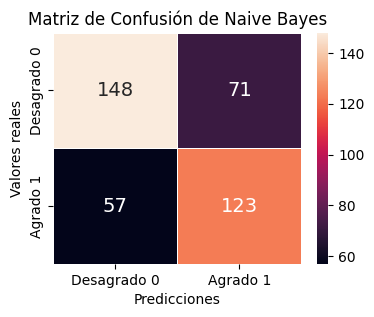

In [ ]:
matriz_confusion(matriz_nv,"Naive Bayes")


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

def encontrar_mejores_parametros_naive_bayes(x, y):
    # Define el modelo de Naive Bayes
    modelo = GaussianNB()

#el paremetro priors proporciona estimaciones iniciales de cuántos elementos pertenecen a cada clase antes de que el modelo vea los datos de entrenamiento.
    parametros = {
        'priors': [None, [0.2, 0.8], [0.5, 0.5]],  # Distribución a priori(probabilidad) de las clases
        'var_smoothing': [1e-9, 1e-7, 1e-5]  # Suavizado de la varianza(Ayuda a evitar problemas cuando se encuentran valores nulos en los datos de entrenamiento)
    }

    #  validación cruzada
    grid_search = GridSearchCV(modelo, parametros, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(x_escalada, y)

    # Devuelve los mejores hiperparámetros encontrados
    mejores_parametros = grid_search.best_params_
    mejor_puntuacion = grid_search.best_score_

    return mejores_parametros, mejor_puntuacion

# Ejemplo de uso
mejores_parametros, mejor_puntuacion = encontrar_mejores_parametros_naive_bayes(x_escalada, y)
print("Mejores Parámetros:", mejores_parametros)
print("Mejor Puntuación:", mejor_puntuacion)


Mejores Parámetros: {'priors': None, 'var_smoothing': 1e-09}
Mejor Puntuación: 0.5396279643833201


#Random forest

He ido probando con la profundidad y la validacion cruzada ,mejoro la matriz de confusion respecto a otros modelos.

En este caso no use los modelos de hiperparametros,lo hice jugando con las varibles y la valizacion,al iguales que arboles de decision el parametro de la profundidad debe ser bajo en lo posible,si bien aumentando la profundidad parace que mejora el score ,no es asi,se estaria sobreajustando y perderia la capacidad de generalizacion en datos no vistos.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#creo el modelo
clf_randomforest = RandomForestClassifier(max_depth = 3,n_estimators = 200)#creara  200 arboles y va a tomar en cuenta la "opinion" de cada uno ,para asi poder etiquetar bien.
#lo ajusto
clf_randomforest.fit(x_train,y_train)
print("Puntaje de solo el modelo",clf_randomforest.score(x_train,y_train))

Puntaje de solo el modelo 0.7699059561128526


In [ ]:
# Realizo validación cruzada y obténgo las puntuaciones
puntuaciones_rf = cross_val_score(clf_randomforest, x_escalada, y, cv=10, scoring='accuracy')
#targets predecidos x el random forest
y_pred_forest = clf_randomforest.predict(x_test)

# Imprimo las puntuaciones
print("Puntuaciones de Validación Cruzada de Random Forest:", puntuaciones_rf)
print("Puntuación Promedio:", puntuaciones_rf.mean())

Puntuaciones de Validación Cruzada de Random Forest: [0.785      0.665      0.795      0.61       0.70351759 0.40703518
 0.70854271 0.67336683 0.73366834 0.68341709]
Puntuación Promedio: 0.6764547738693468


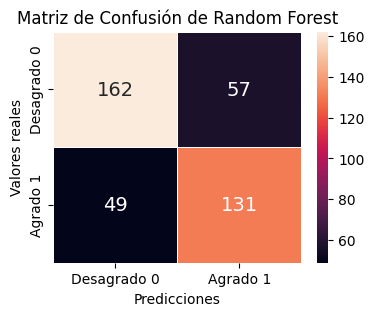

              precision    recall  f1-score   support

           0       0.77      0.74      0.75       219
           1       0.70      0.73      0.71       180

    accuracy                           0.73       399
   macro avg       0.73      0.73      0.73       399
weighted avg       0.74      0.73      0.73       399



In [ ]:
matriz_rf = confusion_matrix(y_test,y_pred_forest)
matriz_confusion(matriz_rf,"Random Forest")
print(classification_report(y_test,y_pred_forest))


#Ensamble: bagging

La matriz de ensamble mejoro aun mas al añadir random forest.

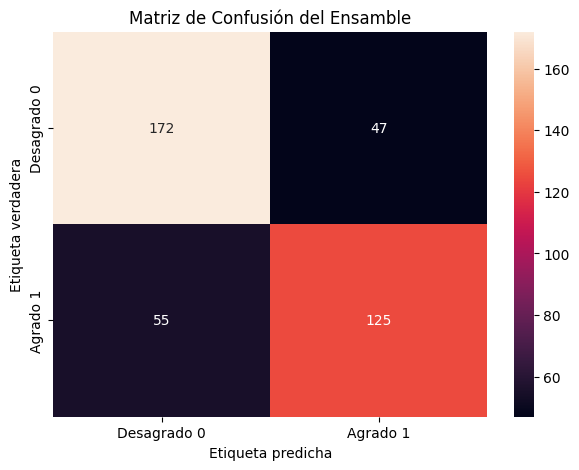

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier




#uso los parametros obtenidos anteriormente para knn,sv,arbol de deciciones,nayve bayes,bosques aleatorios
knn3 = KNeighborsClassifier(n_neighbors=5,metric="euclidean")
knn3.fit(x_train, y_train)

svm2 = SVC(C=2, gamma = 4, kernel='poly')
svm2.fit(x_train, y_train)

naive_bayes = GaussianNB(priors=[0.5, 0.5],var_smoothing=1e-09)
naive_bayes.fit(x_train, y_train)

decision_tree = DecisionTreeClassifier(criterion="entropy",max_depth = 5,min_samples_split=5)
decision_tree.fit(x_train, y_train)
#le agrego un nuevo modelo random forest con los mejores parametros
bosques_aleatorios = RandomForestClassifier(max_depth = 3,n_estimators = 200)
bosques_aleatorios.fit(x_train , y_train)

knn_predictions = knn3.predict(x_test)
svm_predictions = svm2.predict(x_test)
naive_bayes_predictions = naive_bayes.predict(x_test)
decision_tree_predictions = decision_tree.predict(x_test)
random_forest_predictions = bosques_aleatorios.predict(x_test)

# ENSABLE
final_predictions = []
for k, s, n, dt, rf in zip(knn_predictions, svm_predictions, naive_bayes_predictions, decision_tree_predictions , random_forest_predictions):


    votes = {0: 0, 1: 0, 2: 0}
    votes[k] += 1
    votes[s] += 1
    votes[n] += 1
    votes[dt] += 1
    votes[rf] += 1

    majority_vote = max(votes, key=votes.get)
    final_predictions.append(majority_vote)


c4 = confusion_matrix(y_test, final_predictions)

plt.figure(figsize=(7,5))
sns.heatmap(c4, annot=True, fmt='g', xticklabels=['Desagrado 0', 'Agrado 1'], yticklabels=['Desagrado 0', 'Agrado 1'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión del Ensamble')
plt.show()